# Exoplanet Regression 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

### Cleaning Data

In [6]:
exoplanet_data_full = pd.read_csv('exoplanet_data.csv')

def merge(mass, mass_sini):
    if np.isnan(mass):
        return mass_sini
    return mass

#Some data has a Mass_Sini estimate for mass instead of Mass, but we can merge for all intents and purposes
exoplanet_data_full['MASS'] = exoplanet_data_full.apply(lambda row: merge(row['MASS'],row['MASS_SINI']), axis=1)

#Correct a spelling error while cleaning data
exoplanet_data_full = exoplanet_data_full.rename(index = str, columns = {'STAR_METALLICITIY':'STAR_METALLICITY'});

Let's run a quick regression with all data

In [8]:
radius_data = exoplanet_data_full.drop(columns = 'MASS_SINI')

In [9]:
yXstring = 'PLANETARY_RADIUS ~ MASS + SEMI_MAJOR_AXIS+ ORBITAL_PERIOD + ECCENTRICITY + OMEGA + TIME_PERIAPSE + INCLINATION + STAR_MASS + STAR_AGE + STAR_TEMP + STAR_RADIUS + STAR_METALLICITY'

y, X = patsy.dmatrices(yXstring, data=radius_data, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PLANETARY_RADIUS   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.118
Date:                Mon, 15 Jul 2019   Prob (F-statistic):              0.421
Time:                        16:32:35   Log-Likelihood:                -5.2658
No. Observations:                  26   AIC:                             36.53
Df Residuals:                      13   BIC:                             52.89
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -5.4618      3.291     -1.660      0.121     -12.571       1.648
MASS                -0.0253      0.012     -2.181      0.048      -0.050      -0.000
SEMI_MAJOR_AXIS     -6.4216      6.208     -1.034      0.320     -19.833       6.990
ORBITAL_PERIOD       0.0132      0.012      1.062      0.308      -0.014       0.040
ECCENTRICITY         0.3277      0.809      0.405      0.692      -1.420       2.075
OMEGA               -0.0020      0.001     -2.035      0.063      -0.004       0.000
TIME_PERIAPSE     1.475e-08   1.99e-07      0.074      0.942   -4.15e-07    4.44e-07
INCLINATION          0.0110      0.013      0.865      0.403      -0.016       0.038
STAR_MASS           -6.0690      2.791     -2.175      0.049     -12.098      -0.040
STAR_AGE            -0.1080      0.057     -1.898      0.080      -0.231       0.015
STAR_TEMP            0.0021      0.001      2.250      0.042    8.47e-05       0.004
STAR_RADIUS          0.6582      0.524      1.255      0.232      -0.475       1.791
STAR_METALLICITY     2.9555      1.845      1.602      0.133      -1.030       6.941
==============================================================================
Omnibus:                        2.988   Durbin-Watson:                   2.745
Prob(Omnibus):                  0.224   Jarque-Bera (JB):                1.534
Skew:                          -0.285   Prob(JB):                        0.464
Kurtosis:                       4.045   Cond. No.                     2.12e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The horrible adjusted $R^2$ let's us know we have some serious cleaning to do. Many of the features will not help us.

In [10]:
exoplanet_data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4098 entries, 0 to 4097
Data columns (total 16 columns):
NAME                4098 non-null object
MASS                1922 non-null float64
MASS_SINI           948 non-null float64
SEMI_MAJOR_AXIS     2584 non-null float64
ORBITAL_PERIOD      3880 non-null float64
ECCENTRICITY        1526 non-null float64
OMEGA               922 non-null float64
TIME_PERIAPSE       630 non-null float64
PLANETARY_RADIUS    3036 non-null float64
INCLINATION         855 non-null float64
DETECTION_TYPE      4096 non-null object
STAR_MASS           3676 non-null float64
STAR_AGE            1194 non-null float64
STAR_TEMP           3769 non-null float64
STAR_RADIUS         3556 non-null float64
STAR_METALLICITY    3583 non-null float64
dtypes: float64(14), object(2)
memory usage: 544.3+ KB


In [11]:
#Some of the columns have few entries, so dropping columns with under 1000 entries
exoplanet_data=exoplanet_data_full.drop(columns = ['MASS_SINI','OMEGA','TIME_PERIAPSE','INCLINATION','STAR_AGE'])

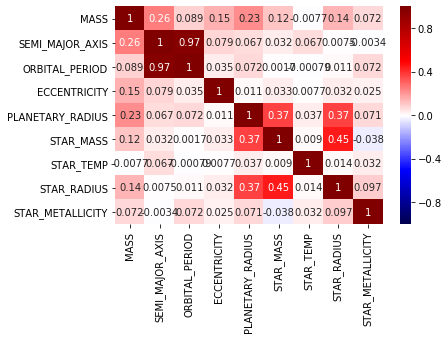

In [12]:
#Heatmap show that semi-major axis and orbital period are far too closely related, should remove one
sns.heatmap(exoplanet_data.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [13]:
#Research shows orbital period is typically directly measured, so removing semi-major-axis
exoplanet_data=exoplanet_data.drop(columns = 'SEMI_MAJOR_AXIS')

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


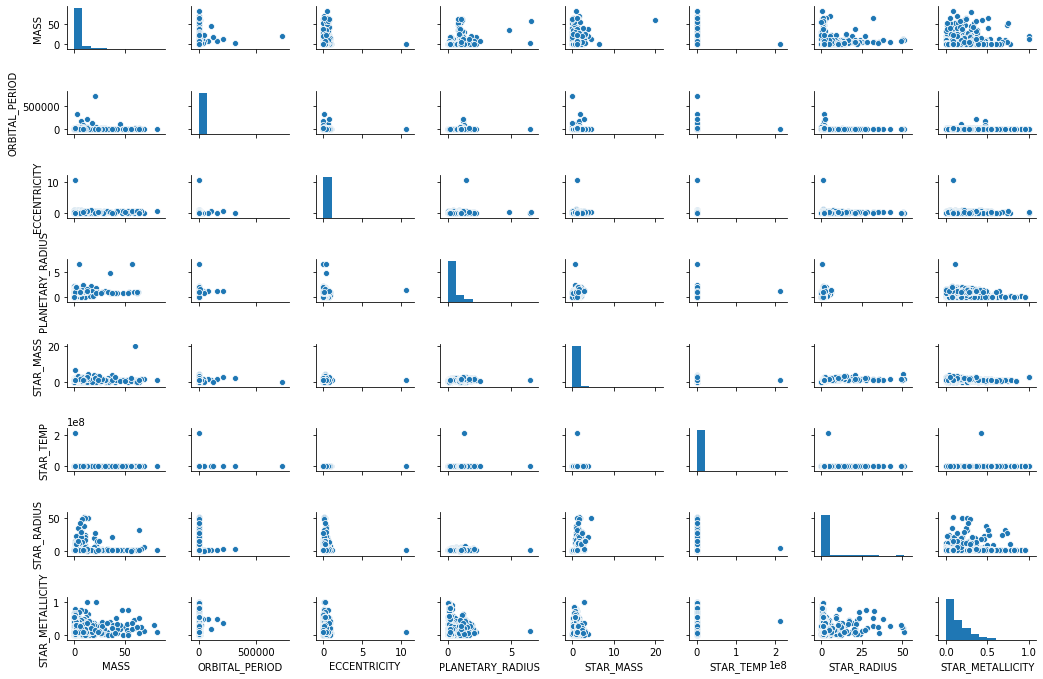

In [14]:
# Pairplot to check on data. Reveals clear outliers in multiple categories.
sns.pairplot(exoplanet_data, height=1.2, aspect=1.5);

In [15]:
yXstring = 'PLANETARY_RADIUS ~ MASS + ORBITAL_PERIOD + ECCENTRICITY + STAR_MASS + STAR_TEMP + STAR_RADIUS + STAR_METALLICITY'
y, X = patsy.dmatrices(yXstring, data=exoplanet_data, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PLANETARY_RADIUS   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     26.01
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           1.23e-30
Time:                        16:32:58   Log-Likelihood:                -339.32
No. Observations:                 538   AIC:                             694.6
Df Residuals:                     530   BIC:                             728.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3803      0.184     -2.068      0.039      -0.742      -0.019
MASS                 0.0016      0.004      0.434      0.664      -0.006       0.009
ORBITAL_PERIOD   -7.463e-06   2.25e-06     -3.315      0.001   -1.19e-05   -3.04e-06
ECCENTRICITY        -0.0064      0.041     -0.156      0.876      -0.087       0.075
STAR_MASS            0.5053      0.168      3.008      0.003       0.175       0.835
STAR_TEMP            0.0001   5.16e-05      2.739      0.006    3.99e-05       0.000
STAR_RADIUS          0.0298      0.042      0.703      0.482      -0.054       0.113
STAR_METALLICITY     0.2166      0.166      1.307      0.192      -0.109       0.542
==============================================================================
Omnibus:                      478.864   Durbin-Watson:                   1.475
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49659.257
Skew:                           3.321   Prob(JB):                         0.00
Kurtosis:                      49.596   Cond. No.                     1.08e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### The original pairplot showed a few unrealistic outliers for some columns, so we filter them out 

In [16]:
#Filtering out the outliers revealed by pairplots
filter_outlier = exoplanet_data['STAR_TEMP'] < exoplanet_data.quantile([.995])['STAR_TEMP'].iloc[0]
exoplanet_data_filtered = exoplanet_data[filter_outlier]

filter_outlier = exoplanet_data_filtered['ORBITAL_PERIOD'] < exoplanet_data_filtered.quantile([.995])['ORBITAL_PERIOD'].iloc[0]
exoplanet_data_filtered = exoplanet_data_filtered[filter_outlier]

filter_outlier = exoplanet_data_filtered['ECCENTRICITY'] < exoplanet_data_filtered.quantile([.995])['ECCENTRICITY'].iloc[0]
exoplanet_data_filtered = exoplanet_data_filtered[filter_outlier]

filter_outlier = exoplanet_data_filtered['PLANETARY_RADIUS'] < exoplanet_data_filtered.quantile([.995])['PLANETARY_RADIUS'].iloc[0]
exoplanet_data_filtered = exoplanet_data_filtered[filter_outlier]

In [17]:
exoplanet_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 682 entries, 17 to 4087
Data columns (total 10 columns):
NAME                682 non-null object
MASS                579 non-null float64
ORBITAL_PERIOD      682 non-null float64
ECCENTRICITY        682 non-null float64
PLANETARY_RADIUS    682 non-null float64
DETECTION_TYPE      682 non-null object
STAR_MASS           664 non-null float64
STAR_TEMP           682 non-null float64
STAR_RADIUS         670 non-null float64
STAR_METALLICITY    634 non-null float64
dtypes: float64(8), object(2)
memory usage: 58.6+ KB


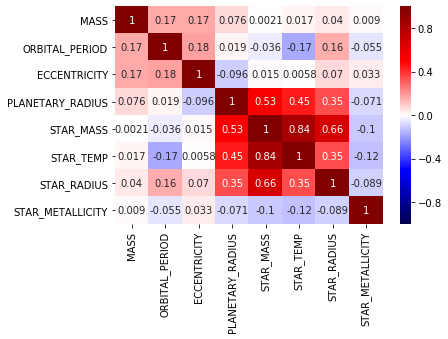

In [18]:
#Much more refined heatmap
sns.heatmap(exoplanet_data_filtered.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

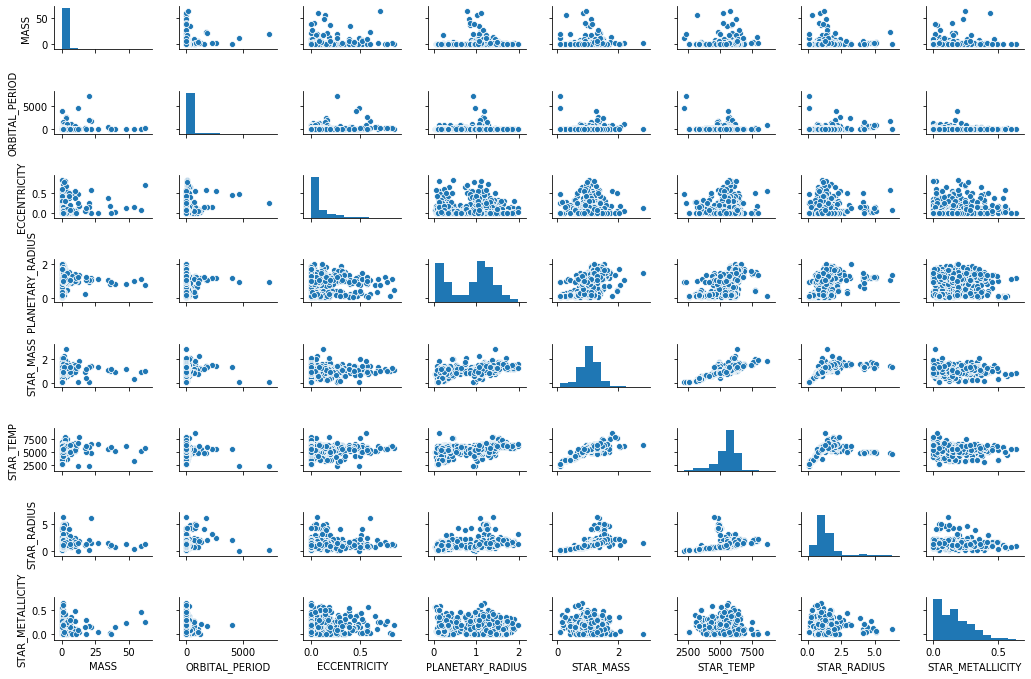

In [19]:
# Better pairplots
sns.pairplot(exoplanet_data_filtered, height=1.2, aspect=1.5);

In [20]:
yXstring = 'PLANETARY_RADIUS ~ MASS + ORBITAL_PERIOD + ECCENTRICITY + STAR_MASS + STAR_TEMP + STAR_RADIUS + STAR_METALLICITY'
y, X = patsy.dmatrices(yXstring, data=exoplanet_data_filtered, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PLANETARY_RADIUS   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     42.26
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           3.29e-47
Time:                        16:33:11   Log-Likelihood:                -229.42
No. Observations:                 531   AIC:                             474.8
Df Residuals:                     523   BIC:                             509.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5179      0.152     -3.400      0.001      -0.817      -0.219
MASS                 0.0016      0.003      0.543      0.587      -0.004       0.007
ORBITAL_PERIOD   -4.401e-06   7.53e-05     -0.058      0.953      -0.000       0.000
ECCENTRICITY        -0.3491      0.118     -2.966      0.003      -0.580      -0.118
STAR_MASS            0.4201      0.139      3.024      0.003       0.147       0.693
STAR_TEMP            0.0002   4.28e-05      4.106      0.000    9.16e-05       0.000
STAR_RADIUS          0.0550      0.036      1.547      0.123      -0.015       0.125
STAR_METALLICITY     0.3165      0.137      2.310      0.021       0.047       0.586
==============================================================================
Omnibus:                       47.634   Durbin-Watson:                   1.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.528
Skew:                          -0.808   Prob(JB):                     1.95e-13
Kurtosis:                       3.192   Cond. No.                     6.60e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Well that was disappointing! How about focusing by detection type? <br>
**Radial Velocity**

In [21]:
#Let's try by data type at least
radial_exoplanet_data=exoplanet_data_full.drop(columns = ['MASS_SINI','SEMI_MAJOR_AXIS','OMEGA','TIME_PERIAPSE','INCLINATION','STAR_AGE'])

In [22]:
radial_exoplanet_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4098 entries, 0 to 4097
Data columns (total 10 columns):
NAME                4098 non-null object
MASS                1922 non-null float64
ORBITAL_PERIOD      3880 non-null float64
ECCENTRICITY        1526 non-null float64
PLANETARY_RADIUS    3036 non-null float64
DETECTION_TYPE      4096 non-null object
STAR_MASS           3676 non-null float64
STAR_TEMP           3769 non-null float64
STAR_RADIUS         3556 non-null float64
STAR_METALLICITY    3583 non-null float64
dtypes: float64(8), object(2)
memory usage: 512.2+ KB


In [23]:
#Radial Velocity Measurements
radial_filter = radial_exoplanet_data['DETECTION_TYPE'] == 'Radial Velocity'
radial_exoplanet_data = radial_exoplanet_data[radial_filter]

#Other filters
filter_outlier = radial_exoplanet_data['STAR_TEMP'] < radial_exoplanet_data.quantile([.995])['STAR_TEMP'].iloc[0]
radial_exoplanet_data = radial_exoplanet_data[filter_outlier]

filter_outlier = radial_exoplanet_data['ORBITAL_PERIOD'] < radial_exoplanet_data.quantile([.995])['ORBITAL_PERIOD'].iloc[0]
radial_exoplanet_data = radial_exoplanet_data[filter_outlier]

filter_outlier = radial_exoplanet_data['ECCENTRICITY'] < radial_exoplanet_data.quantile([.995])['ECCENTRICITY'].iloc[0]
radial_exoplanet_data = radial_exoplanet_data[filter_outlier]

In [24]:
radial_exoplanet_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 731 entries, 0 to 4096
Data columns (total 10 columns):
NAME                731 non-null object
MASS                728 non-null float64
ORBITAL_PERIOD      731 non-null float64
ECCENTRICITY        731 non-null float64
PLANETARY_RADIUS    54 non-null float64
DETECTION_TYPE      731 non-null object
STAR_MASS           731 non-null float64
STAR_TEMP           731 non-null float64
STAR_RADIUS         552 non-null float64
STAR_METALLICITY    690 non-null float64
dtypes: float64(8), object(2)
memory usage: 62.8+ KB


In [25]:
yXstring = 'PLANETARY_RADIUS ~ MASS + ORBITAL_PERIOD + ECCENTRICITY + STAR_MASS + STAR_TEMP + STAR_RADIUS + STAR_METALLICITY'
y, X = patsy.dmatrices(yXstring, data=radial_exoplanet_data, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PLANETARY_RADIUS   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     1.691
Date:                Mon, 15 Jul 2019   Prob (F-statistic):              0.153
Time:                        16:33:11   Log-Likelihood:                -39.883
No. Observations:                  35   AIC:                             95.77
Df Residuals:                      27   BIC:                             108.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.7292      2.579      3.384      0.002       3.437      14.022
MASS                 0.0319      0.042      0.760      0.454      -0.054       0.118
ORBITAL_PERIOD      -0.0001      0.000     -0.520      0.607      -0.001       0.000
ECCENTRICITY        -0.2244      1.052     -0.213      0.833      -2.383       1.934
STAR_MASS            0.7438      1.802      0.413      0.683      -2.954       4.442
STAR_TEMP           -0.0012      0.001     -2.096      0.046      -0.002   -2.59e-05
STAR_RADIUS         -0.4969      0.344     -1.444      0.160      -1.203       0.209
STAR_METALLICITY    -2.2722      1.518     -1.497      0.146      -5.387       0.843
==============================================================================
Omnibus:                       41.345   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.647
Skew:                           2.460   Prob(JB):                     2.42e-42
Kurtosis:                      13.355   Cond. No.                     1.02e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The adjusted $R^2$ dropped precipitously! Oh no! <br>
Further research into the radial velocity methodof detecting exoplanets shows that this method is, by the nature of the measurement, unable to resolve the planetary radius alone. Looking at the data, very few of the radial velocity planets have an estimate for radius (since the estimate must be obtained by other means). So we can safely ignore planets found using radial velocity to predict planetary radius.

**Primary Transit**

In [306]:
transit_exoplanet_data=exoplanet_data_full.drop(columns = ['MASS_SINI','SEMI_MAJOR_AXIS','OMEGA','TIME_PERIAPSE','INCLINATION','STAR_AGE'])

In [307]:
transit_exoplanet_data = transit_exoplanet_data.dropna()

In [308]:
#Transit Data Measurements
transit_filter = transit_exoplanet_data['DETECTION_TYPE'] == 'Primary Transit'
transit_exoplanet_data = transit_exoplanet_data[transit_filter]

#Other filters

filter_outlier = transit_exoplanet_data['ORBITAL_PERIOD'] < transit_exoplanet_data.quantile([.999])['ORBITAL_PERIOD'].iloc[0]
transit_exoplanet_data = transit_exoplanet_data[filter_outlier]

filter_outlier = transit_exoplanet_data['ECCENTRICITY'] < transit_exoplanet_data.quantile([.999])['ECCENTRICITY'].iloc[0]
transit_exoplanet_data = transit_exoplanet_data[filter_outlier]

filter_outlier = transit_exoplanet_data['PLANETARY_RADIUS'] < transit_exoplanet_data.quantile([.999])['PLANETARY_RADIUS'].iloc[0]
transit_exoplanet_data = transit_exoplanet_data[filter_outlier]

In [309]:
transit_exoplanet_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 495 entries, 52 to 4046
Data columns (total 10 columns):
NAME                495 non-null object
MASS                495 non-null float64
ORBITAL_PERIOD      495 non-null float64
ECCENTRICITY        495 non-null float64
PLANETARY_RADIUS    495 non-null float64
DETECTION_TYPE      495 non-null object
STAR_MASS           495 non-null float64
STAR_TEMP           495 non-null float64
STAR_RADIUS         495 non-null float64
STAR_METALLICITY    495 non-null float64
dtypes: float64(8), object(2)
memory usage: 42.5+ KB


In [310]:
yXstring = 'PLANETARY_RADIUS ~ MASS + ORBITAL_PERIOD + ECCENTRICITY + STAR_MASS + STAR_RADIUS + STAR_METALLICITY'
y, X = patsy.dmatrices(yXstring, data=transit_exoplanet_data, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PLANETARY_RADIUS   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     55.34
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           4.98e-52
Time:                        15:31:01   Log-Likelihood:                -208.11
No. Observations:                 495   AIC:                             430.2
Df Residuals:                     488   BIC:                             459.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0481      0.066      0.728      0.467      -0.082       0.178
MASS                 0.0041      0.003      1.380      0.168      -0.002       0.010
ORBITAL_PERIOD      -0.0039      0.001     -6.118      0.000      -0.005      -0.003
ECCENTRICITY        -0.2121      0.119     -1.786      0.075      -0.445       0.021
STAR_MASS            0.9378      0.078     12.066      0.000       0.785       1.090
STAR_RADIUS         -0.0109      0.040     -0.270      0.787      -0.090       0.068
STAR_METALLICITY     0.2063      0.138      1.490      0.137      -0.066       0.478
==============================================================================
Omnibus:                       41.396   Durbin-Watson:                   1.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.882
Skew:                          -0.772   Prob(JB):                     1.47e-11
Kurtosis:                       3.182   Cond. No.                         246.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Feature Engineering

We can try some feature engineering to see if we can improve on our model

In [333]:
feature_data = transit_exoplanet_data
feature_data['STMdivPM'] = feature_data['STAR_MASS']/feature_data['MASS']

In [328]:
feature_data.head()

,NAME,MASS,ORBITAL_PERIOD,ECCENTRICITY,PLANETARY_RADIUS,DETECTION_TYPE,STAR_MASS,STAR_TEMP,STAR_RADIUS,STAR_METALLICITY,STMdivPM,STAR_MASS_Dev_ECCENTRICITY
52,55 Cnc e,0.02703,0.736548,0.028,0.1737,Primary Transit,1.015,5196.0,0.980,0.31,37.550869,-0.629536
75,BD+20 594 b,0.05130,41.685500,0.000,0.1990,Primary Transit,0.961,5766.0,0.928,0.15,18.732943,-0.236105
99,CoRoT-1 b,1.03000,1.508956,0.000,1.4900,Primary Transit,0.950,6298.0,1.110,0.06,0.922330,-0.267523
100,CoRoT-10 b,2.75000,13.240600,0.530,0.9700,Primary Transit,0.890,5075.0,0.790,0.26,0.323636,NaN
101,CoRoT-11 b,2.33000,2.994325,0.000,1.4300,Primary Transit,1.270,6343.0,1.360,0.04,0.545064,0.646460


In [334]:
yXstring = 'PLANETARY_RADIUS ~ MASS + ORBITAL_PERIOD + STAR_MASS + STAR_RADIUS + STAR_METALLICITY + STMdivPM'
y, X = patsy.dmatrices(yXstring, data=feature_data, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PLANETARY_RADIUS   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     100.5
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           4.85e-82
Time:                        15:40:42   Log-Likelihood:                -137.39
No. Observations:                 495   AIC:                             288.8
Df Residuals:                     488   BIC:                             318.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2463      0.059      4.158      0.000       0.130       0.363
MASS              7.871e-05      0.003      0.031      0.976      -0.005       0.005
ORBITAL_PERIOD      -0.0035      0.001     -6.456      0.000      -0.005      -0.002
STAR_MASS            0.8216      0.068     12.084      0.000       0.688       0.955
STAR_RADIUS          0.0003      0.035      0.008      0.994      -0.068       0.069
STAR_METALLICITY    -0.0274      0.121     -0.226      0.821      -0.265       0.211
STMdivPM            -0.0064      0.000    -12.871      0.000      -0.007      -0.005
==============================================================================
Omnibus:                       30.234   Durbin-Watson:                   1.475
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.656
Skew:                          -0.294   Prob(JB):                     1.67e-16
Kurtosis:                       4.782   Cond. No.                         289.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [330]:
def add_deviation_feature(X, feature, category):
    
    # temp groupby object
    category_gb = X.groupby(category)[feature]
    
    # create columns of category means and standard deviations
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    
    # compute stds from category mean for each feature value,
    # returns DataFrame with deviation feature
    deviation_feature = (X[feature] - category_mean) / category_std 
    deviation_dataframe = X
    deviation_dataframe[feature + '_Dev_' + category] = deviation_feature  
    return deviation_dataframe

**Deviation Features**

In [335]:
deviation_data = add_deviation_feature(feature_data, 'STAR_MASS','ECCENTRICITY')

In [336]:
deviation_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 495 entries, 52 to 4046
Data columns (total 12 columns):
NAME                          495 non-null object
MASS                          495 non-null float64
ORBITAL_PERIOD                495 non-null float64
ECCENTRICITY                  495 non-null float64
PLANETARY_RADIUS              495 non-null float64
DETECTION_TYPE                495 non-null object
STAR_MASS                     495 non-null float64
STAR_TEMP                     495 non-null float64
STAR_RADIUS                   495 non-null float64
STAR_METALLICITY              495 non-null float64
STMdivPM                      495 non-null float64
STAR_MASS_Dev_ECCENTRICITY    369 non-null float64
dtypes: float64(10), object(2)
memory usage: 50.3+ KB


In [315]:
dev = deviation_feature_data.dropna()
dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366 entries, 52 to 4045
Data columns (total 12 columns):
NAME                          366 non-null object
MASS                          366 non-null float64
ORBITAL_PERIOD                366 non-null float64
ECCENTRICITY                  366 non-null float64
PLANETARY_RADIUS              366 non-null float64
DETECTION_TYPE                366 non-null object
STAR_MASS                     366 non-null float64
STAR_TEMP                     366 non-null float64
STAR_RADIUS                   366 non-null float64
STAR_METALLICITY              366 non-null float64
STMdivPM                      366 non-null float64
STAR_MASS_Dev_ECCENTRICITY    366 non-null float64
dtypes: float64(10), object(2)
memory usage: 37.2+ KB


In [155]:
final_data = feature_data.copy()

add_deviation_feature(final_data, 'STAR_MASS', 'ECCENTRICITY')

In [156]:
yXstring = 'PLANETARY_RADIUS ~ MASS + ORBITAL_PERIOD + ECCENTRICITY + STAR_MASS + '
yXstring = yXstring + 'STAR_RADIUS + STAR_METALLICITY + STMdivPM + STAR_MASS_Dev_ECCENTRICITY'

y, X = patsy.dmatrices(yXstring, data=final_data, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PLANETARY_RADIUS   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     63.87
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           8.62e-65
Time:                        13:08:44   Log-Likelihood:                -102.10
No. Observations:                 374   AIC:                             222.2
Df Residuals:                     365   BIC:                             257.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3605      0.120      3.005      0.003       0.125       0.596
MASS                           0.0003      0.004      0.087      0.931      -0.007       0.008
ORBITAL_PERIOD                -0.0052      0.001     -4.809      0.000      -0.007      -0.003
ECCENTRICITY                  -0.4877      0.181     -2.688      0.008      -0.844      -0.131
STAR_MASS                      0.7473      0.122      6.107      0.000       0.507       0.988
STAR_RADIUS                   -0.0279      0.051     -0.542      0.588      -0.129       0.073
STAR_METALLICITY               0.0535      0.140      0.381      0.703      -0.223       0.330
STMdivPM                      -0.0057      0.001    -10.965      0.000      -0.007      -0.005
STAR_MASS_Dev_ECCENTRICITY     0.0443      0.040      1.106      0.270      -0.034       0.123
==============================================================================
Omnibus:                       19.243   Durbin-Watson:                   1.395
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.712
Skew:                          -0.357   Prob(JB):                     2.14e-07
Kurtosis:                       4.208   Cond. No.                         392.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Conclusion of OLS Regression 
This regression is the best one I could find through trial and error and feature engineering. Now on to validation testing.

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [158]:
final_data.columns

Index(['NAME', 'MASS', 'ORBITAL_PERIOD', 'ECCENTRICITY', 'PLANETARY_RADIUS',
       'DETECTION_TYPE', 'STAR_MASS', 'STAR_RADIUS', 'STAR_METALLICITY',
       'STMdivPM', 'STAR_MASS_Dev_ECCENTRICITY'],
      dtype='object')

In [159]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 611 entries, 52 to 4045
Data columns (total 11 columns):
NAME                          611 non-null object
MASS                          521 non-null float64
ORBITAL_PERIOD                611 non-null float64
ECCENTRICITY                  611 non-null float64
PLANETARY_RADIUS              611 non-null float64
DETECTION_TYPE                611 non-null object
STAR_MASS                     588 non-null float64
STAR_RADIUS                   603 non-null float64
STAR_METALLICITY              567 non-null float64
STMdivPM                      509 non-null float64
STAR_MASS_Dev_ECCENTRICITY    465 non-null float64
dtypes: float64(9), object(2)
memory usage: 57.3+ KB


In [165]:
validation_data = final_data.drop(columns = ['NAME','DETECTION_TYPE'])
validation_data = validation_data.dropna()

In [166]:
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 52 to 4045
Data columns (total 9 columns):
MASS                          374 non-null float64
ORBITAL_PERIOD                374 non-null float64
ECCENTRICITY                  374 non-null float64
PLANETARY_RADIUS              374 non-null float64
STAR_MASS                     374 non-null float64
STAR_RADIUS                   374 non-null float64
STAR_METALLICITY              374 non-null float64
STMdivPM                      374 non-null float64
STAR_MASS_Dev_ECCENTRICITY    374 non-null float64
dtypes: float64(9)
memory usage: 29.2+ KB


In [167]:
def trainTest(data):
    X, y = data.drop('PLANETARY_RADIUS',axis=1), data['PLANETARY_RADIUS']
    X, X_test, y, y_test = train_test_split(X, y, test_size=.2)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25)
    #set up the 3 models we're choosing from:

    lm = LinearRegression()

    #Feature scaling for train, val, and test so that we can run our ridge model on each
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train.values)
    X_val_scaled = scaler.transform(X_val.values)
    X_test_scaled = scaler.transform(X_test.values)

    lm_reg = Ridge(alpha=1)

    #Feature transforms for train, val, and test so that we can run our poly model on each
    poly = PolynomialFeatures(degree=2) 

    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    X_test_poly = poly.transform(X_test.values)

    lm_poly = LinearRegression()
    #validate

    lm.fit(X_train, y_train)
    R_list = [lm.score(X_val, y_val)]

    lm_reg.fit(X_train_scaled, y_train)
    R_list.append(lm_reg.score(X_val_scaled, y_val))

    lm_poly.fit(X_train_poly, y_train)
    R_list.append(lm_poly.score(X_val_poly, y_val))
    
    return R_list


In [179]:
R_list_total = []
for i in range(10):
    R_list_total.append(trainTest(validation_data))
    
#Average R^2 for the three models over 10 runs
R_data = pd.DataFrame(R_list_total, columns = ['Linear','Ridge','Poly2'])

In [180]:
R_data

,Linear,Ridge,Poly2
0,0.462491,0.462686,0.207131
1,0.601806,0.601132,-387.771822
2,0.621277,0.631556,0.715060
3,0.568016,0.566663,0.619337
4,-0.385247,-0.374361,-28.171124
5,-0.420770,-0.408878,-27.413354
6,0.585232,0.584634,0.471465
7,0.647966,0.647709,-2.354900
8,0.629070,0.628698,-0.030397
9,0.560712,0.559588,-0.387103


In [176]:
Rs = R_data.mean()
Rs

Linear     0.414677
Ridge      0.419545
Poly2    -17.169712
dtype: float64

In [126]:
type(Rs)

pandas.core.series.Series

In [92]:
lm.fit(X,y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.566


In [71]:
from sklearn.model_selection import KFold

X, y = validation_data.drop('PLANETARY_RADIUS',axis=1), validation_data['PLANETARY_RADIUS']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) 

X, y = np.array(X), np.array(y)

In [72]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] 

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.6001558489521457, 0.6556051272227186, 0.503730932693575, -0.13667530785314863, 0.6145594572788586]
Ridge scores:  [0.6012698054024901, 0.6549843461508109, 0.5034173163973902, -0.129599225074307, 0.6131720665410152] 

Simple mean cv r^2: 0.447 +- 0.296
Ridge mean cv r^2: 0.449 +- 0.293


In [73]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.565


In [74]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.39324384, 0.54064444, 0.50857341, 0.57832651, 0.39743046])

In [75]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([ 0.60015585,  0.65560513,  0.50373093, -0.13667531,  0.61455946])

In [76]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

0.5116971224372082
0.5192310099702238
